# 1. Set Up the Database #

In [1]:
import sqlite3
import pandas as pd

connection = sqlite3.connect('student_grades.db')
cursor = connection.cursor()

# 2. Create the Necessary Tables #

In [3]:
# create student table
cursor.execute('''
CREATE TABLE IF NOT EXISTS students (
    student_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT,
    last_name TEXT
)
''')

# create grades table
cursor.execute('''
CREATE TABLE IF NOT EXISTS grades (
    grade_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id INTEGER,
    subject TEXT,
    grade INTEGER,
    FOREIGN KEY (student_id) REFERENCES students (student_id)
)
''')

cursor.close()


# 3. Insert Data into the Tables #

In [5]:
cursor = connection.cursor()

# inserting data into students table 
students_data = [
    ("Alice", "Johnson"),
    ("Bob", "Smith"),
    ("Carol","White"),
    ("David","Brown"),
    ("Eve","Davis")
]

cursor.executemany('''
INSERT INTO students (first_name, last_name) VALUES (?, ?)
''', students_data)

# inserting data into grades table 
grades_data = [
    (1, "Math", 95),
    (1, "English", 88),
    (1, "History", 90),
    (2, "Math" , 82),
    (2, "English", 76),
    (2, "History", 85),
    (3, "Math", 79),
    (3, "English", 91),
    (3, "History", 85),
    (4, "Math" , 90),
    (4, "English", 87),
    (4, "History", 92),
    (5, "Math" , 82),
    (5, "English", 89),
    (5, "History", 85)
]

cursor.executemany('''
INSERT INTO grades (student_id, subject, grade) VALUES (?, ?,?)
''', grades_data)

#committing the changes
connection.commit()

cursor.close()
    

# 4. Perform SQL Queries #

In [7]:
cursor = connection.cursor()

# 1. Retrieve all students' names and their grades.

cursor.execute('''
SELECT students.first_name|| ' ' ||students.last_name, 
grades.subject, grades.grade
FROM Students
JOIN grades ON students.student_id = grades.student_id
''')

result = cursor.fetchall()

print("Students' names and their grades:")
for row in result:
    print(row)



Students' names and their grades:
('Alice Johnson', 'Math', 95)
('Alice Johnson', 'English', 88)
('Alice Johnson', 'History', 90)
('Bob Smith', 'Math', 82)
('Bob Smith', 'English', 76)
('Bob Smith', 'History', 85)
('Carol White', 'Math', 79)
('Carol White', 'English', 91)
('Carol White', 'History', 85)
('David Brown', 'Math', 90)
('David Brown', 'English', 87)
('David Brown', 'History', 92)
('Eve Davis', 'Math', 82)
('Eve Davis', 'English', 89)
('Eve Davis', 'History', 85)


In [25]:
# 2. Average grade for each student

cursor.execute('''
SELECT students.first_name|| ' ' ||students.last_name, 
ROUND(AVG(grades.grade),1)
FROM students
JOIN grades ON students.student_id = grades.student_id
GROUP BY students.student_id
''')

result = cursor.fetchall()
print("Average grade for students:")
for row in result:
    print(row)


Average grade for students:
('Alice Johnson', 91.0)
('Bob Smith', 81.0)
('Carol White', 85.0)
('David Brown', 89.7)
('Eve Davis', 85.3)


In [27]:
# 3. Student with the highest average

cursor.execute('''
SELECT students.first_name|| ' ' ||students.last_name, 
ROUND(AVG(grades.grade),1) AS average_grade
FROM students
JOIN grades ON students.student_id = grades.student_id
GROUP BY students.student_id
ORDER BY average_grade DESC LIMIT 1
''')

result = cursor.fetchone()
print ("Student with the highest average grade: ", result)

Student with the highest average grade:  ('Alice Johnson', 91.0)


In [31]:
# 4. Average grade for the math subject

cursor.execute('''
SELECT AVG(grade)
FROM grades
WHERE subject = 'Math'
''')

avg = cursor.fetchone()[0]
print("Average grade for math:",avg)


Average grade for math: 85.6


In [35]:
# 5. All students who scored above 90 in any subject

cursor.execute('''
SELECT students.first_name|| ' ' ||students.last_name,
grades.grade, grades.subject
FROM students
JOIN grades ON students.student_id = grades.student_id
WHERE grades.grade > 90
''')

result = cursor.fetchall()

print("Students who scored above 90 in any subject:")
for row in result:
    print(row)



Students who scored above 90 in any subject:
('Alice Johnson', 95, 'Math')
('Carol White', 91, 'English')
('David Brown', 92, 'History')


# 5. Load Data into Pandas

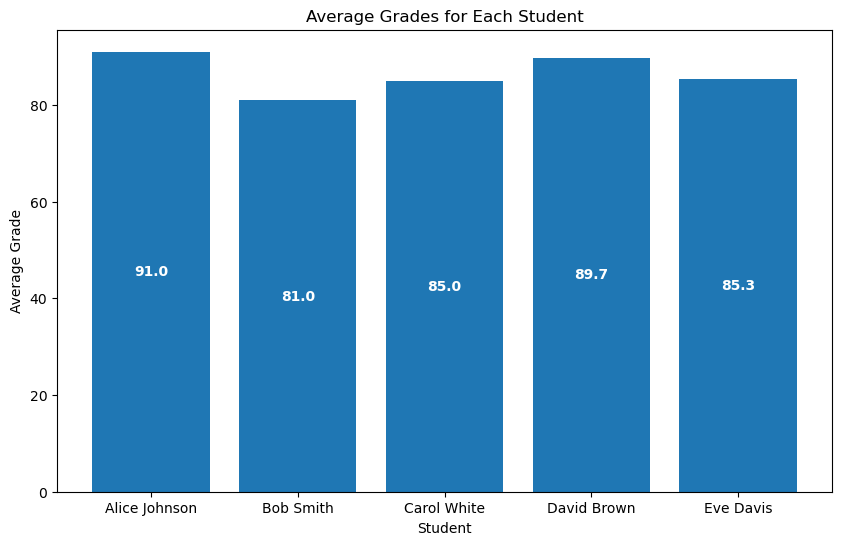

In [66]:
import matplotlib.pyplot as plt

students_df = pd.read_sql_query("SELECT * FROM students", connection)
grades_df = pd.read_sql_query("SELECT * FROM grades", connection)

# merge the dataframes
merged_df = pd.merge(students_df, grades_df, on = "student_id")

cursor.execute('''
SELECT students.first_name|| ' ' ||students.last_name AS full_name, 
ROUND(AVG(grades.grade),1) AS avg
FROM students
JOIN grades ON students.student_id = grades.student_id
GROUP BY students.student_id
''')

result = cursor.fetchall()
average_grades_df = pd.DataFrame(result, columns = ['full_name', 'avg'])

plt.figure(figsize=(10, 6))
bars = plt.bar(average_grades_df['full_name'], average_grades_df['avg'])
plt.xlabel('Student')
plt.ylabel('Average Grade')
plt.title('Average Grades for Each Student')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, f'{yval}', ha='center', va='center', color='white', fontweight = 'bold')
plt.show()


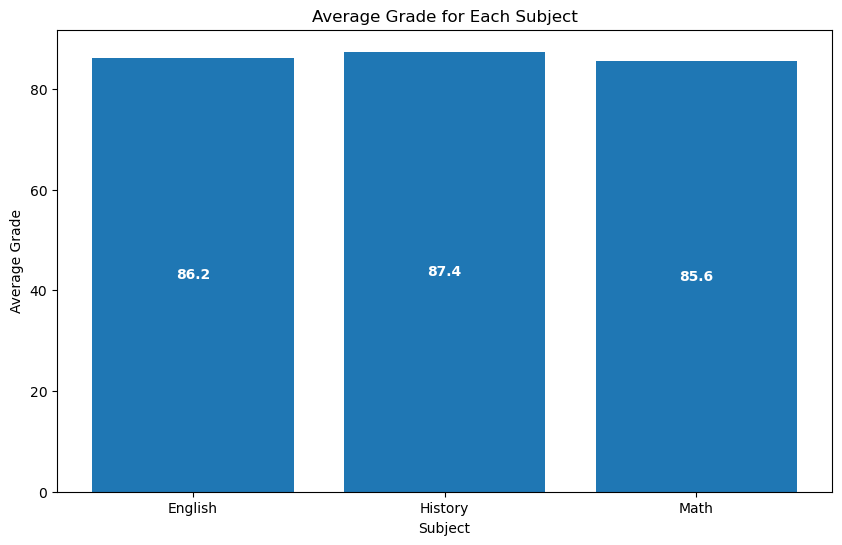

In [64]:
# Create a bar chart showing the average grade for each subject

cursor.execute('''
SELECT AVG(grade) AS avg_grade, subject
FROM grades
GROUP BY subject
''')

avg = cursor.fetchall()
average_df = pd.DataFrame(avg, columns = ['avg_grade', 'subject'])


plt.figure(figsize=(10, 6))
bars = plt.bar(average_df['subject'], average_df['avg_grade'])
plt.xlabel('Subject')
plt.ylabel('Average Grade')
plt.title('Average Grade for Each Subject')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, f'{yval}', ha='center', va='center', color='white', fontweight = 'bold')
plt.show()



# Bonus Task: Find the student with the highest grade in each subject

In [77]:
cursor.execute('''
SELECT grades.subject, 
students.first_name|| ' ' ||students.last_name AS full_name, 
MAX(grades.grade) AS highest_grade
FROM grades
JOIN students ON grades.student_id = students.student_id
GROUP BY grades.subject
''')
results_bonus = cursor.fetchall()

print("Student with the highest grade in each subject:")
for row in results_bonus:
    print(row)

Student with the highest grade in each subject:
('English', 'Carol White', 91)
('History', 'David Brown', 92)
('Math', 'Alice Johnson', 95)


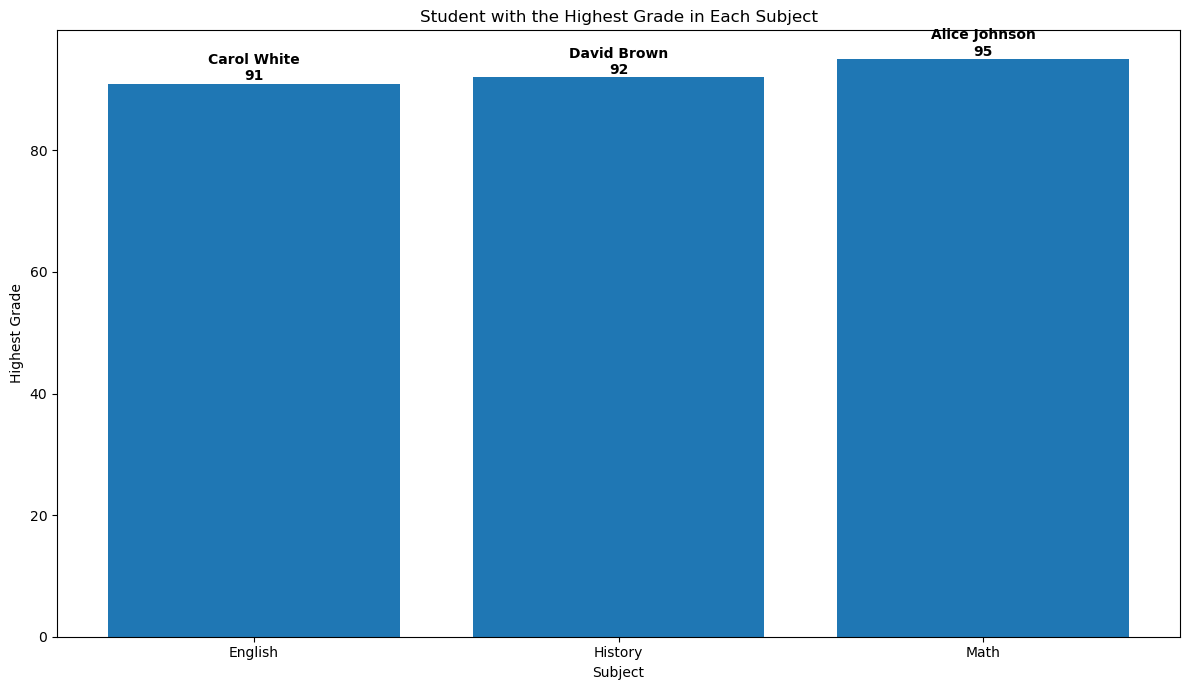

In [93]:
# Visualize the bonus task results using a grouped bar chart
bonus_df = pd.DataFrame(results_bonus, columns=['subject', 'full_name', 'highest_grade'])

plt.figure(figsize=(12, 7))
bars = plt.bar(bonus_df['subject'], bonus_df['highest_grade'])
for i,bar in enumerate(bars):
    height = bar.get_height()
    subject = bar.get_x() + bar.get_width() / 2
    # Extract student name for the specific bar
    full_name = bonus_df.iloc[i]['full_name']
    plt.text(subject, height + 0.1, f'{full_name}\n{height}', ha='center', va='bottom', color='black', fontweight='bold')

plt.xlabel('Subject')
plt.ylabel('Highest Grade')
plt.title('Student with the Highest Grade in Each Subject')
plt.tight_layout()

plt.show()

connection.close()